## Create DataFrame with ML Features

### Import Packages

In [11]:
import ast
import create_reply_trees as crt
import numpy as np
import pandas as pd
import networkx
import treelib
import json
import math
import matplotlib.pyplot as plt

### Build tree and graph dictionaries

In [13]:
from argparse import Namespace

flags = Namespace(initial_tweets='congress_df_2022-10-26_tweets.txt',
                  reply_tweets='congress_df_2022-10-26_reply_tweets.txt',
                  reply_mappings='congress_df_2022-10-26_reply_mappings.txt'
                  )

cid_tree_dict, cid_graph_dict = crt.create_reply_trees_and_graphs(
        flags.reply_tweets, flags.initial_tweets, flags.reply_mappings
    )

Number of reply cids found: 1439
Length of cid_tree_dict: 1621, length of cid_graph_dict: 1621
Built mapping dictionaries.
Added nodes to trees and graphs.
Rerordered trees.
Added graph edges.


### Initialize DataFrame

In [ ]:
conv_df = pd.DataFrame(index=cid_tree_dict.keys())

In [ ]:
conv_df['tree_size'] = np.zeros(len(conv_df))
conv_df['tree_depth'] = np.zeros(len(conv_df))
conv_df['tree_lvl1_breadth'] = np.zeros(len(conv_df))
conv_df['tree_breadth'] = np.zeros(len(conv_df))
conv_df['tree_out_degree_avg'] = np.zeros(len(conv_df))
conv_df['tree_max_replies_exc_orig'] = np.zeros(len(conv_df))
conv_df['tree_dropped_node_count'] = np.zeros(len(conv_df))

conv_df['orig_retweet_count'] = np.zeros(len(conv_df))
conv_df['orig_like_count'] = np.zeros(len(conv_df))
conv_df['orig_quote_count'] = np.zeros(len(conv_df))

In [ ]:
conv_df['graph_user_count'] = np.zeros(len(conv_df))
conv_df['graph_edge_per_user_count'] = np.zeros(len(conv_df))
conv_df['graph_in_degree_author'] = np.zeros(len(conv_df))
conv_df['graph_out_degree_author'] = np.zeros(len(conv_df))
conv_df['graph_avg_out_degree'] = np.zeros(len(conv_df)) # you reply
conv_df['graph_avg_in_degree'] = np.zeros(len(conv_df)) # replies to you

conv_df['graph_nr_conn_comp'] = np.zeros(len(conv_df))
conv_df['graph_max_degree_exc_orig'] = np.zeros(len(conv_df))
conv_df['graph_reciprocity'] = np.zeros(len(conv_df))
conv_df['graph_density'] = np.zeros(len(conv_df))

conv_df['graph_degree_assortativity'] = np.zeros(len(conv_df))
conv_df['graph_dropped_node_count'] = np.zeros(len(conv_df))
conv_df['graph_dropped_edge_count'] = np.zeros(len(conv_df))

conv_df['graph_author_follower_count'] = np.zeros(len(conv_df))
conv_df['graph_author_following_count'] = np.zeros(len(conv_df))
conv_df['graph_author_tweet_count'] = np.zeros(len(conv_df))
conv_df['graph_author_listed_count'] = np.zeros(len(conv_df))

conv_df['graph_avg_user_follower_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_following_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_tweet_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_listed_count'] = np.zeros(len(conv_df))
conv_df['graph_user_verified_frac'] = np.zeros(len(conv_df))

conv_df['graph_follower_assortativity'] = np.zeros(len(conv_df))

### Compute Tree Features

In [ ]:
for cid, tree in cid_tree_dict.items():
    # Basic metrics
    conv_df['tree_size'][cid] = tree.size()
    conv_df['tree_depth'][cid] = tree.depth()
    conv_df['tree_lvl1_breadth'][cid] = tree.size(level=1)
    conv_df['tree_breadth'][cid] = len(tree.leaves())
    
    # Calculation metrics
    out_degree = 0
    max_children = 0
    for node in tree.all_nodes():
        out_degree += len(tree.children(node.tag))
        if node.is_root() == False and len(tree.children(node.tag)) > max_children:
            max_children = len(tree.children(node.tag))
            
    conv_df['tree_out_degree_avg'][cid] = out_degree/tree.size()
    conv_df['tree_max_replies_exc_orig'][cid] = max_children
    
    # Use data in tree to define metrics
    conv_df['tree_dropped_node_count'][cid] = tree[tree.root].data['dropped_node_count']
    conv_df['orig_retweet_count'][cid] = tree[tree.root].data['retweet_count']
    conv_df['orig_like_count'][cid] = tree[tree.root].data['like_count']
    conv_df['orig_quote_count'][cid] = tree[tree.root].data['quote_count']

### Compute Graph Features

In [ ]:
i = 0
for cid, graph in cid_graph_dict.items():
    # Basic metrics
    conv_df['graph_user_count'][cid] = graph.number_of_nodes()
    conv_df['graph_edge_per_user_count'][cid] = graph.number_of_edges()/graph.number_of_nodes()
    
    # Original author metrics
    tree = cid_tree_dict[cid]
    orig_author_id = tree[tree.root].data['author_id']
    
    conv_df['graph_in_degree_author'][cid] = graph.in_degree(orig_author_id)
    conv_df['graph_out_degree_author'][cid] = graph.out_degree(orig_author_id)
    
    # Calculation metrics
    conv_df['graph_avg_out_degree'][cid] = np.mean([deg for (node, deg) in graph.out_degree()])
    conv_df['graph_avg_in_degree'][cid] = np.mean([deg for (node, deg) in graph.in_degree()])
        
    graph_und = graph.to_undirected()
    conv_df['graph_nr_conn_comp'][cid] = networkx.number_connected_components(graph_und)
    
    try:
        conv_df['graph_max_degree_exc_orig'][cid] = max([deg for (node, deg) in graph.degree() if node!=orig_author_id])
    except:
        pass
    
    try:
        conv_df['graph_reciprocity'][cid] = networkx.reciprocity(graph)
    except:
        pass
    
    conv_df['graph_density'][cid] = networkx.density(graph)
    
    if np.isnan(networkx.degree_assortativity_coefficient(graph)):
        conv_df['graph_degree_assortativity'][cid] = 0
    elif math.isinf(networkx.degree_assortativity_coefficient(graph)):
        conv_df['graph_degree_assortativity'][cid] = 0
    elif networkx.degree_assortativity_coefficient(graph) in (None, ''):
        conv_df['graph_degree_assortativity'][cid] = 0
    else:
        conv_df['graph_degree_assortativity'][cid] = networkx.degree_assortativity_coefficient(graph)
        
    conv_df['graph_dropped_node_count'][cid] = graph.graph['dropped_node_count']
    conv_df['graph_dropped_edge_count'][cid] = graph.graph['dropped_edge_count']
    
    graph.nodes[orig_author_id]['follower_attr'] = graph.nodes[orig_author_id]['public_metrics']['followers_count']
    graph.nodes[orig_author_id]['following_attr'] = graph.nodes[orig_author_id]['public_metrics']['following_count']
    graph.nodes[orig_author_id]['tweet_attr'] = graph.nodes[orig_author_id]['public_metrics']['tweet_count']
    
    conv_df['graph_author_follower_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['followers_count']
    conv_df['graph_author_following_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['following_count']
    conv_df['graph_author_tweet_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['tweet_count']
    conv_df['graph_author_listed_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['listed_count']
    
    user_follower_count = 0
    user_following_count = 0
    user_tweet_count = 0
    user_listed_count = 0
    user_verified_count = 0
    
    for node in graph.nodes:
        if node != orig_author_id:
            try:
                user_metrics = graph.nodes[node]['public_metrics']
                user_follower_count += user_metrics['followers_count']
                user_following_count += user_metrics['following_count']
                user_tweet_count += user_metrics['tweet_count']
                user_listed_count += user_metrics['listed_count']
                user_verified_count += 1 if graph.nodes[node]['verified']==True else 0 
                
                graph.nodes[node]['follower_attr'] = user_metrics['followers_count']
                graph.nodes[node]['following_attr'] = user_metrics['following_count']
                graph.nodes[node]['tweet_attr'] = user_metrics['tweet_count']
            except:
                graph.nodes[node]['follower_attr'] = 0
                graph.nodes[node]['following_attr'] = 0
                graph.nodes[node]['tweet_attr'] = 0
                #pass
        
    if graph.number_of_nodes() != 1:
        conv_df['graph_avg_user_follower_count'][cid] = user_follower_count/graph.number_of_nodes()
        conv_df['graph_avg_user_following_count'][cid] = user_following_count/graph.number_of_nodes()
        conv_df['graph_avg_user_tweet_count'][cid] = user_tweet_count/graph.number_of_nodes()
        conv_df['graph_avg_user_listed_count'][cid] = user_listed_count/graph.number_of_nodes()
    conv_df['graph_user_verified_frac'][cid] = (user_verified_count+1)/graph.number_of_nodes() # all congress members are verified
    
    # Add assortativity for follower count, following count, and tweet count
    conv_df['graph_follower_assortativity'][cid] = networkx.attribute_assortativity_coefficient(graph, 'follower_attr')
    if np.isnan(conv_df['graph_follower_assortativity'][cid]):
        conv_df['graph_follower_assortativity'][cid] = 0

### Compute output measure

In [ ]:
congress_df = pd.read_csv('congress_df_2022-10-26.csv', index_col=0)

congress_df['twitter_id'] = congress_df['twitter_id'].astype(str)

conv_df['y'] = np.zeros(len(conv_df))

for cid, tree in cid_tree_dict.items():
    author_id = tree[tree.root].data['author_id']
    index_author = np.where(congress_df['twitter_id']==author_id)[0][0]
    party = congress_df['party'].iloc[index_author]
    if party=='Democrat':
        conv_df['y'][cid] = 1

conv_df

,tree_size,tree_depth,tree_lvl1_breadth,tree_breadth,tree_out_degree_avg,tree_max_replies_exc_orig,tree_dropped_node_count,orig_retweet_count,orig_like_count,orig_quote_count,...,graph_author_following_count,graph_author_tweet_count,graph_author_listed_count,graph_avg_user_follower_count,graph_avg_user_following_count,graph_avg_user_tweet_count,graph_avg_user_listed_count,graph_user_verified_frac,graph_follower_assortativity,y
1587162493889044480,7.0,2.0,5.0,5.0,0.857143,1.0,0.0,18.0,119.0,2.0,...,345.0,9168.0,4531.0,375.571429,767.000000,7362.142857,5.000000,0.142857,-3.330669e-17,1.0
1586007771207671809,13.0,4.0,9.0,9.0,0.923077,1.0,0.0,33.0,167.0,2.0,...,345.0,9168.0,4531.0,354.727273,381.818182,9285.363636,1.454545,0.090909,0.000000e+00,1.0
1587835066520068096,4.0,1.0,3.0,3.0,0.750000,0.0,0.0,2.0,15.0,0.0,...,3445.0,14193.0,3127.0,220.250000,260.500000,14286.000000,2.250000,0.250000,0.000000e+00,1.0
1587551050436816897,2.0,1.0,1.0,1.0,0.500000,0.0,0.0,3.0,8.0,0.0,...,3445.0,14193.0,3127.0,77.000000,111.000000,8741.000000,4.000000,0.500000,0.000000e+00,1.0
1587512649818013711,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,2.0,6.0,0.0,...,3445.0,14193.0,3127.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587445605969829895,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,5.0,26.0,0.0,...,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,1.0
1586795070392602624,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,8.0,20.0,0.0,...,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,1.0
1586060066658177027,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,5.0,14.0,0.0,...,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,1.0
1586004936286171137,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,27.0,65.0,1.0,...,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,1.0


### Compute Pairwise Correlations Between Columns (Filter out Collinear Columns)

In [ ]:
conv_df.corr()

,tree_size,tree_depth,tree_lvl1_breadth,tree_breadth,tree_out_degree_avg,tree_max_replies_exc_orig,tree_dropped_node_count,orig_retweet_count,orig_like_count,orig_quote_count,...,graph_author_following_count,graph_author_tweet_count,graph_author_listed_count,graph_avg_user_follower_count,graph_avg_user_following_count,graph_avg_user_tweet_count,graph_avg_user_listed_count,graph_user_verified_frac,graph_follower_assortativity,y
tree_size,1.000000,0.734276,0.982039,0.999774,0.110696,0.803218,0.738249,0.845181,0.958564,0.888658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.058773
tree_depth,0.734276,1.000000,0.777304,0.732476,0.308342,0.437420,0.436394,0.716780,0.654174,0.728451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.151917
tree_lvl1_breadth,0.982039,0.777304,1.000000,0.984190,0.129247,0.699783,0.692580,0.860708,0.905529,0.917313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.084382
tree_breadth,0.999774,0.732476,0.984190,1.000000,0.111519,0.799722,0.739402,0.843679,0.955193,0.890641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.061212
tree_out_degree_avg,0.110696,0.308342,0.129247,0.111519,1.000000,0.069170,0.069766,0.147691,0.096570,0.146484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.372267
tree_max_replies_exc_orig,0.803218,0.437420,0.699783,0.799722,0.069170,1.000000,0.689659,0.613915,0.838678,0.606482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012881
tree_dropped_node_count,0.738249,0.436394,0.692580,0.739402,0.069766,0.689659,1.000000,0.575633,0.758199,0.660799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006073
orig_retweet_count,0.845181,0.716780,0.860708,0.843679,0.147691,0.613915,0.575633,1.000000,0.832325,0.916806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.057883
orig_like_count,0.958564,0.654174,0.905529,0.955193,0.096570,0.838678,0.758199,0.832325,1.000000,0.845573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024968
orig_quote_count,0.888658,0.728451,0.917313,0.890641,0.146484,0.606482,0.660799,0.916806,0.845573,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.092962


#### Drop constant columns

In [ ]:
conv_df = conv_df.drop(columns=['graph_dropped_edge_count'])

### Visualize Feature Distributions

In [ ]:
republicans = conv_df[conv_df['y'] == 0]
democrats = conv_df[conv_df['y'] == 1]

In [ ]:
def create_ccdf_plot(plt, df, feature, color, label):
    # getting data of the histogram
    count, bins_count = np.histogram(df[feature], bins=10000)

    # finding the PDF of the histogram using count values
    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    ccdf = 1-cdf

    # plotting PDF and CDF
    plt.plot(bins_count[1:], 1-cdf, color=color, label=label)

In [ ]:
def create_single_ccdf_plot(df, feature):
    plt.figure(1)
    create_ccdf_plot(plt, df, feature, "blue", "CCDF")
    plt.title('CCDF for ' + feature)
    plt.xscale("log")
    plt.ylim(0, 1)
    plt.legend()
    plt.savefig('ccdf_{}.png'.format(feature))

In [ ]:
def create_joint_ccdf_plot(rep_df, dem_df, feature, x_lim):
    plt.figure(0)
    create_ccdf_plot(plt, rep_df, feature, "red", "Republicans")
    create_ccdf_plot(plt, dem_df, feature, "blue", "Democrats")
    plt.title('CCDF for ' + feature)
    plt.xlim(0, x_lim)
    plt.ylim(0, 1)
    plt.legend()
    plt.savefig('joint_ccdf_{}.png'.format(feature))

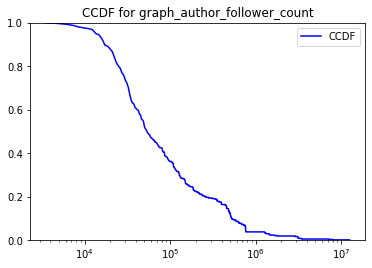

In [ ]:
create_single_ccdf_plot(conv_df, 'graph_author_follower_count')

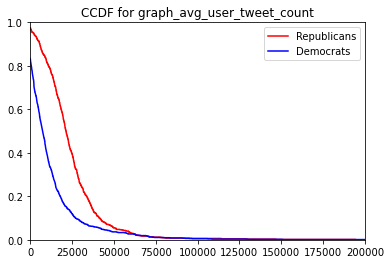

In [ ]:
create_joint_ccdf_plot(republicans, democrats, 'graph_avg_user_tweet_count', 200000)

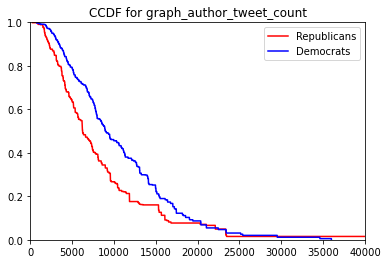

In [ ]:
create_joint_ccdf_plot(republicans, democrats, 'graph_author_tweet_count', 40000)

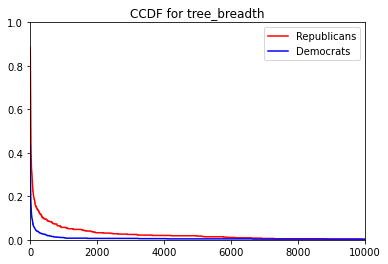

In [ ]:
create_joint_ccdf_plot(republicans, democrats, 'tree_breadth', 10000)

## Classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.inspection import permutation_importance

In [ ]:
def create_train_test(conv_df, test_frac=0.25, r_seed=1):
    X = conv_df.loc[:, conv_df.columns!='y']
    y = conv_df['y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state=r_seed)
    
    return X_train, X_test, y_train, y_test

In [ ]:
def create_param_dict(method):
    if method=='LR':
        param_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
    elif method=='RF':
        param_dict = {'max_depth': [2, 5, 10, 25, 50, 100],
                      'n_estimators': [25, 50, 100, 200, 500]}
    elif method=='GB':
        param_dict = {'max_depth': [2, 5, 10, 25],
                      'n_estimators': [25, 100, 250],
                      'learning_rate': [0.01, 0.01, 0.1, 1, 10]}
    return param_dict

In [ ]:
def k_fold_cv(method, param_dict, X_train, y_train, cv_splits=5, seed=1):
    if method=='LR':
        gs_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                             param_grid=param_dict,
                             cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed),
                             scoring='accuracy')
        gs_cv.fit(X_train, y_train)
    elif method=='RF':
        gs_cv = GridSearchCV(estimator=RandomForestClassifier(),
                             param_grid=param_dict,
                             cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed),
                             scoring='accuracy')
        gs_cv.fit(X_train, y_train)
    elif method=='GB':
        gs_cv = GridSearchCV(estimator=GradientBoostingClassifier(),
                             param_grid=param_dict,
                             cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed),
                             scoring='accuracy')
        gs_cv.fit(X_train, y_train)
    
    return gs_cv

In [ ]:
def model_predictions(gs_cv, X_train, y_train, X_test, y_test):
    y_hat = gs_cv.predict(X_test)
    
    accuracy = np.sum(y_hat==y_test)/len(y_test)
    f_1 = f1_score(y_test, y_hat)
    
    class_report = classification_report(y_test, y_hat, output_dict=True)
    
    precision_democrat = class_report['1.0']['precision']
    precision_republican = class_report['0.0']['precision']
    recall_democrat = class_report['1.0']['recall']
    recall_republican = class_report['0.0']['recall']
    
    return {'accuracy': accuracy, 'f_1': f_1, 'precision_democrat': precision_democrat,
            'precision_republican': precision_republican, 
            'recall_democrat': recall_democrat, 'recall_republican': recall_republican}

In [ ]:
X_train, X_test, y_train, y_test = create_train_test(conv_df)
lr_param_dict = create_param_dict('LR')
rf_param_dict = create_param_dict('RF')
gb_param_dict = create_param_dict('GB')

lr_cv = k_fold_cv('LR', lr_param_dict, X_train, y_train)
print('lr done')
rf_cv = k_fold_cv('RF', rf_param_dict, X_train, y_train)
print('rf done')
gb_cv = k_fold_cv('GB', gb_param_dict, X_train, y_train)
print('gb done')

print('LR:', model_predictions(lr_cv, X_train, y_train, X_test, y_test))
print('RF:', model_predictions(rf_cv, X_train, y_train, X_test, y_test))
print('GB:', model_predictions(gb_cv, X_train, y_train, X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..........................C=0.0001;, score=0.718 total time=   0.2s
[CV 2/5] END ..........................C=0.0001;, score=0.747 total time=   0.2s
[CV 3/5] END ..........................C=0.0001;, score=0.684 total time=   0.4s
[CV 4/5] END ..........................C=0.0001;, score=0.775 total time=   0.3s
[CV 5/5] END ..........................C=0.0001;, score=0.750 total time=   0.8s
[CV 1/5] END ...........................C=0.001;, score=0.731 total time=   0.6s
[CV 2/5] END ...........................C=0.001;, score=0.759 total time=   0.8s
[CV 3/5] END ...........................C=0.001;, score=0.684 total time=   0.4s
[CV 4/5] END ...........................C=0.001;, score=0.779 total time=   0.3s
[CV 5/5] END ...........................C=0.001;, score=0.750 total time=   0.3s
[CV 1/5] END ............................C=0.01;, score=0.731 total time=   0.4s
[CV 2/5] END ............................C=0.01;,

[CV 1/5] END ....max_depth=10, n_estimators=500;, score=0.869 total time=   1.6s
[CV 2/5] END ....max_depth=10, n_estimators=500;, score=0.849 total time=   1.4s
[CV 3/5] END ....max_depth=10, n_estimators=500;, score=0.820 total time=   1.4s
[CV 4/5] END ....max_depth=10, n_estimators=500;, score=0.844 total time=   1.5s
[CV 5/5] END ....max_depth=10, n_estimators=500;, score=0.852 total time=   1.5s
[CV 1/5] END .....max_depth=25, n_estimators=25;, score=0.853 total time=   0.0s
[CV 2/5] END .....max_depth=25, n_estimators=25;, score=0.849 total time=   0.0s
[CV 3/5] END .....max_depth=25, n_estimators=25;, score=0.836 total time=   0.0s
[CV 4/5] END .....max_depth=25, n_estimators=25;, score=0.824 total time=   0.0s
[CV 5/5] END .....max_depth=25, n_estimators=25;, score=0.816 total time=   0.0s
[CV 1/5] END .....max_depth=25, n_estimators=50;, score=0.869 total time=   0.1s
[CV 2/5] END .....max_depth=25, n_estimators=50;, score=0.845 total time=   0.1s
[CV 3/5] END .....max_depth=

[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=25;, score=0.762 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=25;, score=0.754 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.816 total time=   0.8s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.845 total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.824 total time=   0.7s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.799 total time=   0.8s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.832 total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=250;, score=0.857 total time=   2.1s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=250;, score=0.869 total time=   2.4s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=250;, score=0.832 total time=   2.1s
[CV 4/5] END learning_rate=0.01, max_depth

[CV 5/5] END learning_rate=0.01, max_depth=10, n_estimators=250;, score=0.832 total time=   4.7s
[CV 1/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.812 total time=   0.4s
[CV 2/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.804 total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.811 total time=   0.4s
[CV 4/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.783 total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.832 total time=   0.5s
[CV 1/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.820 total time=   2.0s
[CV 2/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.816 total time=   2.0s
[CV 3/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.799 total time=   2.0s
[CV 4/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.791 total time=   2.0s
[CV 5/5] END learning_rate=0.01, ma

[CV 2/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.890 total time=   0.9s
[CV 3/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.910 total time=   1.0s
[CV 4/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.914 total time=   0.9s
[CV 5/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.910 total time=   0.9s
[CV 1/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.890 total time=   0.2s
[CV 2/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.886 total time=   0.1s
[CV 3/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.844 total time=   0.1s
[CV 4/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.869 total time=   0.1s
[CV 5/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.885 total time=   0.1s
[CV 1/5] END learning_rate=1, max_depth=5, n_estimators=100;, score=0.922 total time=   0.8s
[CV 2/5] END learning_rate=1, max_depth=5, n_estimators=100;, score=0.914 t

[CV 5/5] END learning_rate=10, max_depth=10, n_estimators=100;, score=0.803 total time=   1.8s
[CV 1/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.820 total time=   2.3s
[CV 2/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.771 total time=   4.9s
[CV 3/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.779 total time=   1.8s
[CV 4/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.754 total time=   4.7s
[CV 5/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.775 total time=   4.6s
[CV 1/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.796 total time=   0.5s
[CV 2/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.812 total time=   0.4s
[CV 3/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.779 total time=   0.4s
[CV 4/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.787 total time=   0.4s
[CV 5/5] END learning_rate=10, max_depth=25, n_estimat

In [ ]:
gb_cv.best_params_

{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 250}

In [ ]:
gb_clf = GradientBoostingClassifier(learning_rate=1, max_depth=5, n_estimators=250)
gb_clf.fit(X_train, y_train)

### Determine Most Important Features

In [ ]:
feature_imp_dict = {}
feat_imp_vec = gb_clf.feature_importances_
for j in range(len(X_train.columns)):
    feature_imp_dict[X_train.columns[j]] = feat_imp_vec[j]
feature_imp_sort = dict(sorted(feature_imp_dict.items(), key=lambda item: item[1], reverse=True))

top_6_features = []
for col_name, importance in feature_imp_sort.items():
    top_6_features.append(col_name)
    if len(top_6_features)==6:
        break

print(top_6_features)

['graph_avg_user_tweet_count', 'graph_author_tweet_count', 'graph_author_listed_count', 'graph_author_following_count', 'graph_author_follower_count', 'tree_breadth']
